In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns

game_dat = pd.read_csv('../possibility_app/static/stim_data/HMTG_possib_stim.csv', header=0, index_col=0)

# 1. Define generative models

In [2]:

def mp_model_ppsoe(inv, mult, theta, phi):
    inv = float(inv)
    mult = float(mult)
    exp = float(2*inv)
    theta = float(theta)
    phi = float(phi)
    total_amt = inv*mult
    choice_opts = np.arange(0, total_amt+1)  # Only integers in strategy space (but not further discretized)
    own = total_amt-choice_opts
    other = 10 - inv + choice_opts
    own_share = own/total_amt # Should be total_amt
    guilt = np.square(np.maximum((exp-choice_opts)/(inv*4),0))
    inequity = np.square(own/(own+other) - .5)

    utility = theta*own_share - (1-theta)*np.minimum(guilt+phi, inequity-phi)

    return choice_opts[np.where(utility == np.max(utility))[0][0]]

# Difference-making

In [3]:
thetas = np.linspace(0,.5, 20)
phis = np.linspace(.1, -.1, 20)
possibilities = list(itertools.product(phis, thetas))

In [4]:
game = game_dat.loc[game_dat.trustee == 92].reset_index(drop=True)
tru_phi = .001
tru_theta = .3
game['ret'] = [mp_model_ppsoe(i, v, tru_theta, tru_phi) for (i,v) in zip(game.inv, game.mult)]


# Use rational model to compute counterfactuals
cf_outcomes = {possib: [mp_model_ppsoe(game.inv[t], game.mult[t], possib[1], possib[0]) for t in range(len(game))] for possib in possibilities}
def monoExp(x, m, t, b):
    return  m * np.exp(t * x) + b

In [5]:
possibilities = list(itertools.product(phis, thetas))

thresh = 1
n_possibilities = 8
# compare CF to actual
for t in range(1, 10):
    # scale each possible difference by decay function
    decay = [monoExp(x, 1, 1, 1) for x in range(t)]
    decay = decay/sum(decay)
    # distance between CFs and actual
    # if the distance between CF and actual is small, then removing the candidate would have made a difference.
    difference = {possib: np.linalg.norm(np.multiply(cf_outcomes[possib][:t] - game.ret[:t], decay)) for possib in possibilities}
    if len(possibilities) > n_possibilities:
        possibilities = [k for (k,v) in difference.items() if v < thresh]


True Theta: 0.3
True Phi: 0.001


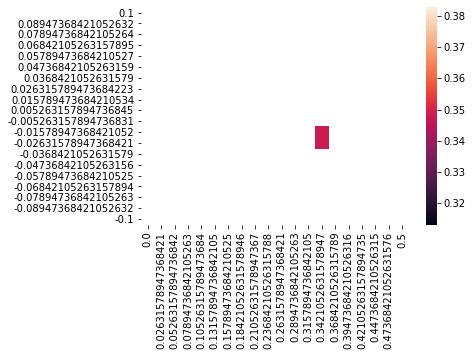

In [6]:
xx = pd.DataFrame(index=phis, columns=thetas)
for poss in possibilities:
    xx.at[poss[0], poss[1]] = difference[poss]

for col in thetas:
    xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

print(f'True Theta: {tru_theta}')
print(f'True Phi: {tru_phi}')

sns.heatmap(xx)

# How cause